![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/rl_banner.png?raw=true)

# Actor-Critic

Actor-Critic models are Policy Gradient methods with a Critic, typically a Value function. This will be very close to our [REINFORCE w/ Baseline](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/REINFORCE%20with%20Baseline/reinforce_with_baseline.ipynb) with one key difference: We will have an ```ONLINE``` model. In REINFORCE w/ Baseline we waited for a full episode to finish before we updated, so we could estimate our returns $G_t$. This method is analogous to using a Monte Carlo method. Now we will be using 1-step returns so very close to standard TD(0) learning. 

## Definition Confusion

### What is A Value Function

There are two types of Values:

- State-Values typically written as $V(s)$
- Action-Values typically written as $Q(s,a)$

We can estimate either of them with a neural network! Typically, if we are estimating the value of a state, our neural network will have a single output. If we are estimating the value of a state/action, then our neural network will have an output for each action I could take. 

### Recap REINFORCE w/ Baseline
Technically our REINFORCE w/ Baseline was an actor-critic (or atleast feels like one), because we were computing the Value function so we could estimate our Advantages. But atleast according to Sutton, this isn't enough to be an Actor Critic. But I guess the difference comes to this. 

*Although the REINFORCE-with-baseline method learns both a policy and a state-value function, we do not consider it to be an actor–critic method because its state-value function is used only as a baseline, not as a critic. That is, it is not used for bootstrapping (updating the value estimate for a state from the estimated values of subsequent states), but only as a baseline for the state whose estimate is being updated.*

Lets remind ourselves, what was our loss function for REINFORCE with Baseline:

$$ E_{\pi} \left[\sum_{t=0}^{T-1}(G_t - V(s_t))\nabla_\theta \ln\pi_\theta(a|s)\right]$$

Notice that although we compute our Values $V(s_t)$, they don't play a role at all in the computation of the returns. They are just some number we subtract from the returns that we can estimate from our full trajectory $G_t$. This loss function forces the policy to maximize its Advantage function essentially!

### Recap Policy Gradients

To get to the heart of this, we have to remind ourselves the original form of the Policy Gradient. 

$$\nabla_\theta J(\theta) \propto E_{\pi} \left[Q_\pi(s,a)\nabla_\theta \ln\pi_\theta(a|s)\right]$$


But in REINFORCE, because our $Q_\pi(s,a)$ is unkown we estimate it with our monte carlo returns $G_t$. What if we only have a single step, and not monte carlo (the entire trajectory). Well, we can't just use $G_t$ anymore, because we needed the full trajectory for that! 

hmmm... Wait, we solved that already didn't we? When we explored our Model-Free learning (before we even talked about Deep RL), we learned about [Monte-Carlo](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/monte_carlo.ipynb) vs [Q-Learning](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/q_learning.ipynb) (and also [SARSA](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/sarsa.ipynb) but that is also in the same spirit of things). 

In Monte Carlo, we did exactly what we had done in REINFORCE, store the trajectory and compute our final returns $G_t$, using that to update our $Q$ table. In Q-Learning we turned to Online-updates, using Bootstrapping to update at every step. And to do that we have our setup like so:

$$Q(s,a) = Q(s,a) - \alpha_t(\text{TD Target} - Q(s,a))$$

where our **TD Target** was:

- Q Learning: $r + \gamma * max_{a'}Q(s',a')$ -> Off policy, select the max $a'$ regardless of what the policy says
- SARSA Learning: $r + \gamma * Q(s',a')$ -> On policy, select the $a'$ that the policy said

So when we moved onto [Deep Q-Learning](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Deep%20Q-Learning/deep_q_learning.ipynb) we updated our model such that the Value it estimated for a specific state/action pair moved closer to our TD Target!

### Moving from REINFORCE To Actor-Critic

Why not employ the same idea here? Instead of using Monte Carlo $G_t$ to estimate $Q_\pi(s,a)$, why not use our Bootstrapped estimates for this (and we will be on-policy here)

$$\nabla_\theta J(\theta) \propto E_{\pi} \left[(r + \gamma Q(s',a') - Q(s,a))\nabla_\theta \ln\pi_\theta(a|s)\right]$$

Notice now our value estimation of the Q function is being used in both the current state/action $s,a$ and the next state/action $s',a'$. Therefore our Value function is being used for both our estimation of our future rewards and our current rewards, and this is the main difference between Actor Critic and REINFORCE with Baseline

### Actor-Critic is a Family of Algorithms

There is no single Actor Critic method. We could do actor critic directly on the Value function like so:

$$\nabla_\theta J(\theta) \propto E_{\pi} \left[(r + \gamma V(s') - V(s))\nabla_\theta \ln\pi_\theta(a|s)\right]$$

Or we could do it on the Advantage Function

$$\nabla_\theta J(\theta) \propto E_{\pi} \left[A(s,a)\nabla_\theta \ln\pi_\theta(a|s)\right]$$

where $A(s,a) = Q(s,a) - V(s)$ 

Or really any other estimate we can think of! The [GAE](https://arxiv.org/abs/1506.02438) paper gives a list here of things you could try:

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Generalized%20Advantage%20Estimate/src/gae_paper_fig.png?raw=true" alt="drawing" width="500"/>


### Lets Implement Actor Critic for the Values

For now lets keep it simple and estimate for the Values function!

$$\nabla_\theta J(\theta) \propto E_{\pi} \left[(r + \gamma V(s') - V(s))\nabla_\theta \ln\pi_\theta(a|s)\right]$$

#### Models:

our Policy and Value models are the same as before!

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Video

class ActorPolicyNetwork(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(ActorPolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pi = F.softmax(self.fc3(x), dim=-1)
        return pi

class CriticValueNetwork(nn.Module):
    def __init__(self, input_state_features=8, hidden_features=128):
        super(CriticValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value
        

### Train Script

To train this model also isn't much different. But we will update our models at every step now (using our TD-Estimates as a target for our Value function)

In [2]:
def train(env, 
          input_state_features=8, 
          num_actions=4,
          hidden_features=128,
          learning_rate=0.0005,
          episodes=5000, 
          running_avg_steps=20, 
          print_freq=50,
          gamma=0.99,
          entropy_weight=0.005,
          device="cpu"):

    policy_network = ActorPolicyNetwork(
        input_state_features=input_state_features, 
        num_actions=num_actions,
        hidden_features=hidden_features
    ).to(device)
    
    value_network = CriticValueNetwork(
        input_state_features=input_state_features, 
        hidden_features=hidden_features
    ).to(device)

    p_optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)
    v_optimizer = optim.Adam(value_network.parameters(), lr=learning_rate)

    log = {"scores": [], 
           "running_avg_scores": []}
    
    for i in range(episodes):

        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:

            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            ### Get Policy for this State ###
            action_probs = policy_network(state_tensor)

            ### Get Value for this state ###
            value = value_network(state_tensor)

            ### Sample an Action to Take ###
            action = torch.multinomial(action_probs, num_samples=1).item()

            ### Get the Log Prob of that selected action ###
            log_prob = torch.log(action_probs[0, action])

            ### Take Step in the Environment ###
            next_state, reward, terminal, truncated, _ = env.step(action)
            done = terminal or truncated

            ### Get the Next State we are in ###
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

            ### Get the Value of the Next State V(S_{t+1}), unless we are terminal, then there is no future Value ###
            next_value = value_network(next_state_tensor).detach() if not done else torch.tensor([[0.0]]).to(device)

            ### Compute TD Target: r + gamma * V(S_{t+1})
            td_target = reward + gamma * next_value

            ### Compute TD Error (how far off is our value estimate from our target): TD Target - V(s_t) ###
            ### Also dont want grads to flow from policy to value models so detach ###
            td_error = td_target - value.detach()

            ### Compute Entropy to encourage some randomness ###
            entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8))
            
            ### Compute Policy Loss ###
            policy_loss = -log_prob * td_error - entropy_weight * entropy
 
            ### Move Value model towards TD Target ###
            value_loss = F.smooth_l1_loss(value, td_target)

            ### Update Policy Network ###
            p_optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1.0)
            p_optimizer.step()

            ### Update Value Network ###
            v_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(value_network.parameters(), max_norm=1.0)
            v_optimizer.step()

            ### Set the Nexts State ###
            state = next_state
            total_reward += reward

        log["scores"].append(total_reward)
        running_avg = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg)

        if i % print_freq == 0:
            print(f"Episode {i}, Total Reward: {total_reward:.2f}, Avg Reward: {running_avg:.2f}")

        if running_avg >= 200:
            print("Completed Training")
            break
            
    return policy_network, value_network, log


### Play Game ###
env = gym.make("LunarLander-v3")
policy_network, value_network, log = train(env, device="cuda")
        

Episode 0, Total Reward: -133.31, Avg Reward: -133.31
Episode 50, Total Reward: -246.48, Avg Reward: -146.30
Episode 100, Total Reward: -198.84, Avg Reward: -236.11
Episode 150, Total Reward: -248.39, Avg Reward: -267.38
Episode 200, Total Reward: -345.24, Avg Reward: -294.47
Episode 250, Total Reward: -404.13, Avg Reward: -287.26
Episode 300, Total Reward: -172.69, Avg Reward: -261.76
Episode 350, Total Reward: -169.76, Avg Reward: -201.08
Episode 400, Total Reward: -163.27, Avg Reward: -161.51
Episode 450, Total Reward: 21.28, Avg Reward: -2.27
Episode 500, Total Reward: -69.48, Avg Reward: -3.01
Episode 550, Total Reward: -41.72, Avg Reward: -51.88
Episode 600, Total Reward: -179.99, Avg Reward: -168.35
Episode 650, Total Reward: -146.81, Avg Reward: -135.69
Episode 700, Total Reward: -81.80, Avg Reward: -146.53
Episode 750, Total Reward: -94.77, Avg Reward: -35.64
Episode 800, Total Reward: -8.97, Avg Reward: 85.77
Episode 850, Total Reward: -62.43, Avg Reward: -21.44
Episode 900, 

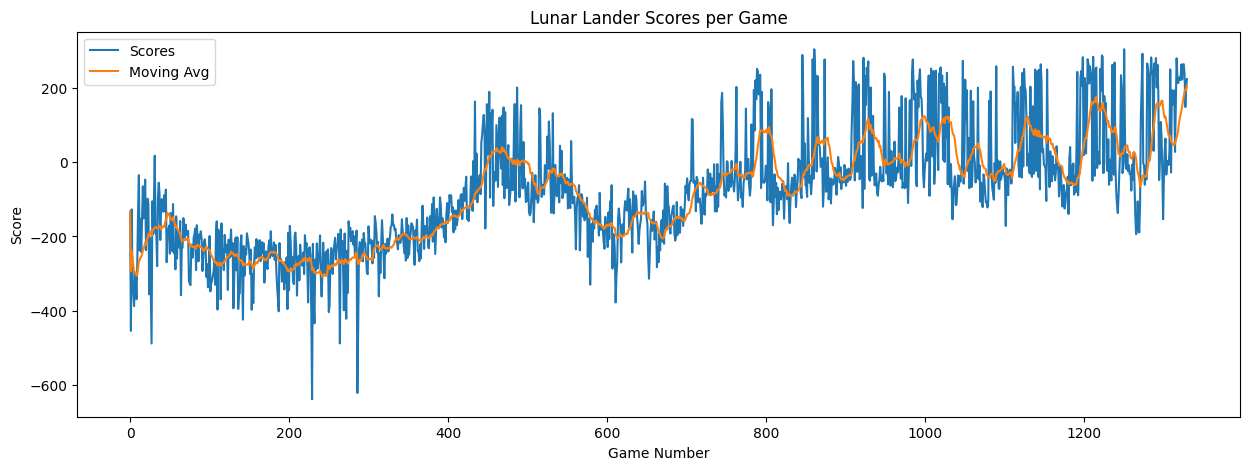

In [3]:
plt.figure(figsize=(15,5))
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

In [4]:
from IPython.display import Video
def record_game(env, policy, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset()
    
    while not done:

        ### Get Predicted Action ###
        action = policy(torch.tensor(state, device=device).unsqueeze(0)).argmax(axis=-1).item()

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()

env = gym.make("LunarLander-v3", render_mode="rgb_array")
record_game(env, policy_network, prefix="policy-network")

Video("savevideos/policy-network-episode-0.mp4", embed=True)

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/analysisdrive/analysis/NCSA_HAL_Tutorials/PyTorch for Reinforcement Learning/Deep RL Policy Models/Vanilla Actor Critic/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
